In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

### Load data

In [4]:
data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis/')

In [5]:
data = pd.read_csv(
    data_dir / 'prd_merged_015H_20200215T0300Z_20200217T0900Z.csv',
    index_col=0)

In [6]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

### Data pre-processing

In [7]:
# drop NaN values in the dataset
data = data.dropna()

# drop data points with zero precip in the radar data
# data = data[data[target_parameter]>0]

In [8]:
data['raining'] = np.where(data[target_parameter]>0, 1, 0)

In [14]:
data['raining'].value_counts()

1    153522
0     57618
Name: raining, dtype: int64

In [9]:
data[data[target_parameter]>1]

,realization,latitude,longitude,cloud_area_fraction,latitude_longitude,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0,period_midpoint,day_of_year,hour,rainfall_rate_composite,raining
126,0,50.15625,-3.796875,1.00000,-2147483647,50.0625,-3.9375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,26.0625,27.0625,30.0000,30.5000,30.1250,2020-02-15 01:27:30,46,1.0,1.804155,1
127,1,50.15625,-3.796875,1.00000,-2147483647,50.0625,-3.9375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,25.5625,27.4375,29.7500,31.6250,31.3750,2020-02-15 01:27:30,46,1.0,1.804155,1
128,2,50.15625,-3.796875,1.00000,-2147483647,50.0625,-3.9375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,25.7500,26.6875,29.5625,32.1250,30.2500,2020-02-15 01:27:30,46,1.0,1.804155,1
129,3,50.15625,-3.796875,1.00000,-2147483647,50.0625,-3.9375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,25.1250,25.2500,27.2500,29.6875,28.8750,2020-02-15 01:27:30,46,1.0,1.804155,1
130,4,50.15625,-3.796875,1.00000,-2147483647,50.0625,-3.9375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,25.3125,29.4375,30.9375,31.3125,31.5625,2020-02-15 01:27:30,46,1.0,1.804155,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211315,30,57.84375,-3.796875,0.81250,-2147483647,57.7500,-3.9375,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,32.0000,34.0625,33.8750,33.3750,32.8125,2020-02-17 07:27:30,48,7.0,1.135063,1
211316,31,57.84375,-3.796875,0.71875,-2147483647,57.7500,-3.9375,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,33.2500,33.5625,34.5000,34.7500,35.5000,2020-02-17 07:27:30,48,7.0,1.135063,1
211317,32,57.84375,-3.796875,0.53125,-2147483647,57.7500,-3.9375,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,32.8125,32.2500,31.8125,31.5625,32.1250,2020-02-17 07:27:30,48,7.0,1.135063,1
211318,33,57.84375,-3.796875,0.84375,-2147483647,57.7500,-3.9375,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,35.0000,35.2500,34.5000,33.5000,33.0625,2020-02-17 07:27:30,48,7.0,1.135063,1


In [10]:
target_parameter='raining'

In [11]:
# Get a list of columns names for profile features
prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

features = data[prof_feature_columns + single_lvl_features]

target = data[[target_parameter]]

In [12]:
target

,raining
0,1
1,1
2,1
3,1
4,1
...,...
211675,0
211676,0
211677,0
211678,0


In [13]:
# data_control uses only the control member

# data_control = data[data['realization']==0]

# # Get a list of columns names for profile features
# prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

# features = data_control[prof_feature_columns + single_lvl_features]

# target = data_control[[target_parameter]]

In [14]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,211140.0,281.135109,2.343883,271.812500,279.812500,281.062500,282.812500,288.125000
air_temperature_10.0,211140.0,281.157152,2.345967,271.875000,279.812500,281.062500,282.812500,288.187500
air_temperature_20.0,211140.0,281.200546,2.356563,272.000000,279.875000,281.000000,282.875000,288.375000
air_temperature_30.0,211140.0,281.133797,2.359426,271.937500,279.812500,280.937500,282.812500,288.312500
air_temperature_50.0,211140.0,280.996481,2.372186,271.750000,279.625000,280.812500,282.750000,288.125000
...,...,...,...,...,...,...,...,...
relative_humidity_4500.0,211140.0,0.602580,0.270457,0.007812,0.390625,0.659180,0.851562,1.012695
relative_humidity_5000.0,211140.0,0.579609,0.274178,0.007812,0.361328,0.643555,0.831055,1.004883
relative_humidity_5500.0,211140.0,0.557362,0.275903,0.006836,0.325195,0.628906,0.810547,1.005859
relative_humidity_6000.0,211140.0,0.531477,0.276030,0.006836,0.288086,0.604492,0.785156,0.986328


In [15]:
standardScaler = StandardScaler()

features = pd.DataFrame(standardScaler.fit_transform(features), 
                                columns=features.columns,
                                index=features.index)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,211140.0,-1.051902e-14,1.000002,-3.977429,-0.564282,-0.030978,0.715648,2.982191
air_temperature_10.0,211140.0,7.710503e-16,1.000002,-3.956652,-0.573177,-0.040347,0.705616,2.996788
air_temperature_20.0,211140.0,1.110700e-14,1.000002,-3.904232,-0.562493,-0.085101,0.710551,3.044464
air_temperature_30.0,211140.0,-6.577619e-15,1.000002,-3.897694,-0.560009,-0.083197,0.711489,3.042571
air_temperature_50.0,211140.0,-1.099716e-14,1.000002,-3.897883,-0.578152,-0.077558,0.739201,3.005049
...,...,...,...,...,...,...,...,...
relative_humidity_4500.0,211140.0,-2.670677e-16,1.000002,-2.199127,-0.783694,0.209275,0.920602,1.516384
relative_humidity_5000.0,211140.0,-6.892069e-17,1.000002,-2.085501,-0.796131,0.233228,0.917093,1.551092
relative_humidity_5500.0,211140.0,-3.015280e-17,1.000002,-1.995367,-0.841482,0.259310,0.917662,1.625566
relative_humidity_6000.0,211140.0,-6.009023e-16,1.000002,-1.900670,-0.881757,0.264519,0.919029,1.647834


In [16]:
processed_data = pd.concat([features, target], axis=1, sort=False)

Split the dataset into 60/20/20 subsets for training, testing and validation

In [17]:
# Height profiles data
X_train_prof, X_test_prof, y_train, y_test = train_test_split(
    features[prof_feature_columns],
    target,
    test_size=0.2,
    random_state=1
)

# Single level data
X_train_singlvl, X_test_singlvl, y_train, y_test = train_test_split(
    features[single_lvl_features],
    target,
    test_size=0.2,
    random_state=1
)

# y_test and y_train is the same in both of these, given that the random state is set

Oversample data - https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [19]:
X_train_prof

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,relative_humidity_2750.0,relative_humidity_3000.0,relative_humidity_3250.0,relative_humidity_3500.0,relative_humidity_3750.0,relative_humidity_4000.0,relative_humidity_4500.0,relative_humidity_5000.0,relative_humidity_5500.0,relative_humidity_6000.0
21695,1.648930,1.664711,1.665334,1.665114,1.687696,1.675392,1.657791,1.614471,1.613039,1.589052,...,1.086092,1.126293,1.173476,1.196295,1.227948,1.236806,1.205855,1.130800,1.115875,1.117151
79416,0.448996,0.465842,0.498377,0.526063,0.581119,0.652979,0.720320,0.790394,0.800193,0.786314,...,-0.935591,-0.792059,-0.636565,-0.596695,-0.693999,-0.937319,-1.697226,-1.985771,-1.871483,-1.780382
75367,0.848974,0.892107,0.975769,0.976385,0.949978,0.967567,0.980729,0.944909,0.901799,0.861571,...,-0.213561,-0.351102,-0.417852,-0.517259,-0.750749,-1.165977,-1.910263,-2.007142,-1.570624,0.144231
153315,-0.724274,-0.679743,-0.615536,-0.612989,-0.630846,-0.631592,-0.633805,-0.600235,-0.647688,-0.693735,...,0.466667,0.440360,0.381583,0.333844,0.297241,0.265947,0.230940,0.161992,-0.480450,-1.072804
94094,1.488939,1.504862,1.506203,1.506176,1.529614,1.544313,1.553628,1.562966,1.587637,1.589052,...,1.257100,1.280817,1.343167,1.321123,1.231731,1.165585,1.119196,1.052441,1.045084,1.000400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109529,0.582322,0.599050,0.604464,0.605531,0.633813,0.626763,0.616156,0.584375,0.571580,0.585629,...,1.112693,1.156444,1.131996,1.022291,1.091747,1.109357,1.140861,1.134362,1.130033,1.145454
50165,1.142291,1.131881,1.134899,1.135322,1.160755,1.151077,1.136974,1.099423,1.079609,1.087341,...,1.048091,0.964232,0.943450,0.957986,1.008513,1.030639,1.003651,0.995452,0.988452,1.039317
5192,-0.750939,-0.733026,-0.721623,-0.718947,-0.736234,-0.736454,-0.737969,-0.677492,-0.622287,-0.568307,...,-2.235245,-2.084780,-1.828175,-1.428885,-0.833983,0.056031,0.725619,0.215419,-0.632650,-0.687173
209320,-2.404182,-2.384801,-2.365971,-2.361299,-2.369753,-2.335613,-2.326461,-2.325645,-2.324182,-2.349383,...,-0.775985,-0.844823,-0.723296,-0.596695,-0.618332,-0.716158,-0.527328,-0.094457,-0.105261,-0.336922


In [23]:
data[data['raining']==0]

,realization,latitude,longitude,cloud_area_fraction,latitude_longitude,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0,period_midpoint,day_of_year,hour,rainfall_rate_composite,raining
198,0,50.15625,-2.671875,1.000000,-2147483647,50.0625,-2.8125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,23.4375,23.2500,26.5625,28.8125,29.4375,2020-02-15 01:27:30,46,1.0,0.0,0
199,1,50.15625,-2.671875,1.000000,-2147483647,50.0625,-2.8125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,23.1875,25.0625,28.8750,30.5000,29.7500,2020-02-15 01:27:30,46,1.0,0.0,0
200,2,50.15625,-2.671875,1.000000,-2147483647,50.0625,-2.8125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,25.7500,27.0000,27.9375,28.9375,30.5625,2020-02-15 01:27:30,46,1.0,0.0,0
201,3,50.15625,-2.671875,1.000000,-2147483647,50.0625,-2.8125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,22.0625,21.7500,25.1250,28.0625,27.7500,2020-02-15 01:27:30,46,1.0,0.0,0
202,4,50.15625,-2.671875,1.000000,-2147483647,50.0625,-2.8125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,21.8750,24.1250,27.8125,29.6875,30.5000,2020-02-15 01:27:30,46,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211675,30,57.84375,1.828125,0.062500,-2147483647,57.7500,1.6875,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,33.3750,33.0000,32.0625,30.8750,29.9375,2020-02-17 07:27:30,48,7.0,0.0,0
211676,31,57.84375,1.828125,0.484375,-2147483647,57.7500,1.6875,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,28.6250,29.2500,29.8125,29.6250,29.3125,2020-02-17 07:27:30,48,7.0,0.0,0
211677,32,57.84375,1.828125,0.000000,-2147483647,57.7500,1.6875,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,29.8750,30.1875,30.6250,31.0625,31.1250,2020-02-17 07:27:30,48,7.0,0.0,0
211678,33,57.84375,1.828125,0.359375,-2147483647,57.7500,1.6875,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,33.8125,34.4375,35.0625,35.1250,34.9375,2020-02-17 07:27:30,48,7.0,0.0,0


In [ ]:
ids = y_train[y_train['raining']==0].index
choices = np.random.choice(ids, len(y_train[y_train['raining']==1]))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

In [19]:
# reshape height profile variables 
X_train_prof = np.transpose(X_train_prof.to_numpy().reshape(X_train_prof.shape[0], 2, 33), (0, 2, 1))
X_test_prof = np.transpose(X_test_prof.to_numpy().reshape(X_test_prof.shape[0], 2, 33), (0, 2, 1))

In [20]:
def build_model(nprof_features, nheights, nsinglvl_features):#, output_bias=None):
    
    # if output_bias is not None:
    #     output_bias = tf.keras.initializers.Constant(output_bias)

    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True,  activation='sigmoid', name='main_output')(x) # bias_initializer=output_bias,
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='sigmoid', name='main_output')(out) # bias_initializer=output_bias,
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [21]:
nprof_features = len(profile_features)
nheights = len(prof_feature_columns)//len(profile_features)
nsinglvl_features = len(single_lvl_features)

Calculate and set initial bias 

In [23]:
no_rain, rain = np.bincount(y_train['raining'])
no_rain, rain
initial_bias = np.log([rain/no_rain])
initial_bias

array([0.9812743])

In [24]:
import keras.metrics
model = build_model(nprof_features, nheights, nsinglvl_features)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 2)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       192         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-06-24 16:35:34.727757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
if nsinglvl_features > 0:
    X_train = [X_train_prof, X_train_singlvl]
    X_test = [X_test_prof, X_test_singlvl]
else:
    X_train = X_train_prof
    X_test = X_test_prof

In [26]:
history = model.fit(X_train, y_train, epochs=30, batch_size=1000, validation_split=0.25, verbose=True)

Epoch 1/30
127/127 [==============================] - 15s 102ms/step - loss: 0.3784 - tp: 84017.0000 - fp: 12045.0000 - tn: 22522.0000 - fn: 8100.0000 - accuracy: 0.8410 - precision: 0.8746 - recall: 0.9121 - auc: 0.8953 - prc: 0.9522 - val_loss: 0.2871 - val_tp: 29505.0000 - val_fp: 4098.0000 - val_tn: 7387.0000 - val_fn: 1238.0000 - val_accuracy: 0.8736 - val_precision: 0.8780 - val_recall: 0.9597 - val_auc: 0.9377 - val_prc: 0.9755
Epoch 2/30
127/127 [==============================] - 12s 97ms/step - loss: 0.2687 - tp: 86460.0000 - fp: 8911.0000 - tn: 25656.0000 - fn: 5657.0000 - accuracy: 0.8850 - precision: 0.9066 - recall: 0.9386 - auc: 0.9419 - prc: 0.9768 - val_loss: 0.2677 - val_tp: 28696.0000 - val_fp: 2610.0000 - val_tn: 8875.0000 - val_fn: 2047.0000 - val_accuracy: 0.8897 - val_precision: 0.9166 - val_recall: 0.9334 - val_auc: 0.9421 - val_prc: 0.9756
Epoch 3/30
127/127 [==============================] - 12s 96ms/step - loss: 0.2488 - tp: 86928.0000 - fp: 8218.0000 - tn: 26

## Evaluation

In [27]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

In [28]:
training_hist_df

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,...,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc,epoch
0,0.378412,84017.0,12045.0,22522.0,8100.0,0.840982,0.874612,0.912068,0.895264,0.952237,...,29505.0,4098.0,7387.0,1238.0,0.873638,0.878047,0.959731,0.937676,0.975496,0
1,0.268690,86460.0,8911.0,25656.0,5657.0,0.885005,0.906565,0.938589,0.941889,0.976810,...,28696.0,2610.0,8875.0,2047.0,0.889718,0.916629,0.933416,0.942083,0.975564,1
2,0.248850,86928.0,8218.0,26349.0,5189.0,0.894170,0.913628,0.943669,0.950254,0.979884,...,28034.0,1868.0,9617.0,2709.0,0.891612,0.937529,0.911882,0.953887,0.982096,2
3,0.237902,87100.0,7787.0,26780.0,5017.0,0.898930,0.917934,0.945537,0.954663,0.981927,...,28767.0,2273.0,9212.0,1976.0,0.899380,0.926772,0.935725,0.952938,0.980480,3
4,0.225443,87390.0,7363.0,27204.0,4727.0,0.904566,0.922293,0.948685,0.959433,0.983885,...,29068.0,2338.0,9147.0,1675.0,0.904968,0.925556,0.945516,0.960576,0.984385,4
5,0.217216,87469.0,7061.0,27506.0,4648.0,0.907573,0.925304,0.949542,0.962421,0.985173,...,28861.0,1895.0,9590.0,1882.0,0.910557,0.938386,0.938783,0.965788,0.986928,5
6,0.209602,87606.0,6805.0,27762.0,4511.0,0.910675,0.927922,0.951030,0.965048,0.986130,...,28707.0,1748.0,9737.0,2036.0,0.910391,0.942604,0.933774,0.966572,0.987016,6
7,0.205510,87632.0,6646.0,27921.0,4485.0,0.912136,0.929506,0.951312,0.966273,0.986539,...,29460.0,2318.0,9167.0,1283.0,0.914725,0.927056,0.958267,0.968853,0.987764,7
8,0.196770,87696.0,6251.0,28316.0,4421.0,0.915759,0.933463,0.952007,0.969184,0.987787,...,29454.0,2233.0,9252.0,1289.0,0.916596,0.929529,0.958072,0.969638,0.988189,8
9,0.192485,87829.0,6228.0,28339.0,4288.0,0.916990,0.933785,0.953451,0.970571,0.988352,...,29463.0,2296.0,9189.0,1280.0,0.915317,0.927706,0.958364,0.967524,0.986535,9


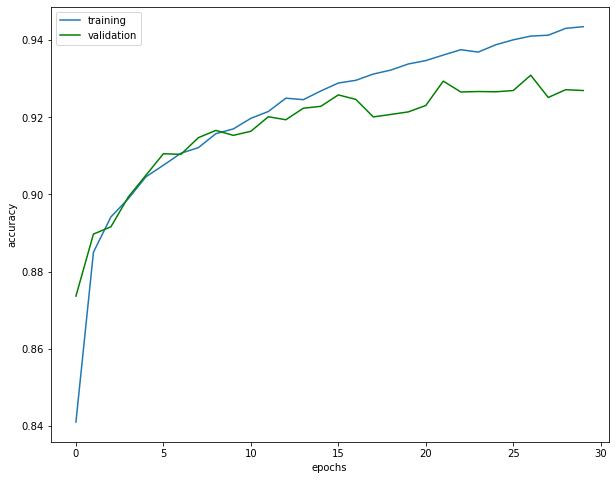

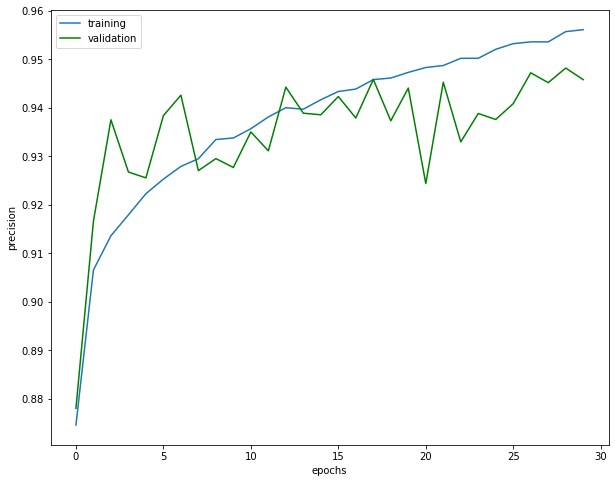

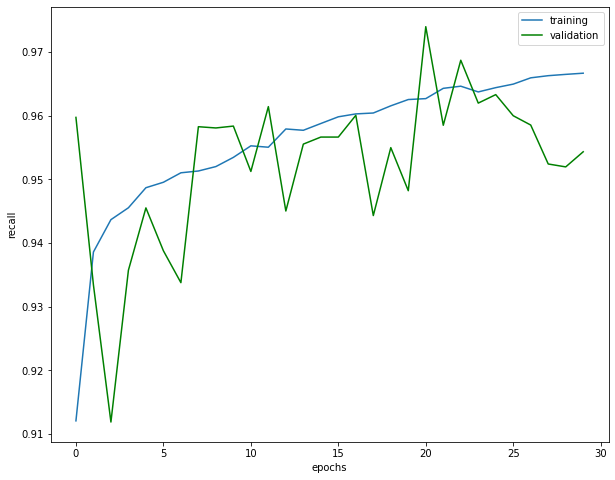

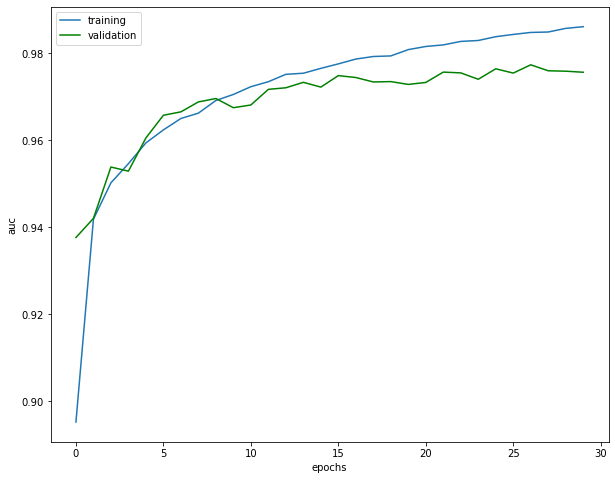

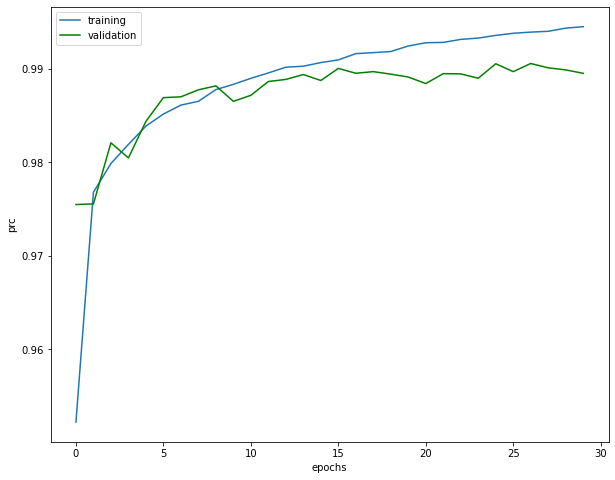

In [29]:
metrics = ['accuracy', 'precision', 'recall', 'auc', 'prc']
for metric in metrics:
    plt.figure(figsize=(10, 8))
    plt.plot(training_hist_df.epoch, training_hist_df[metric], label='training')
    plt.plot(training_hist_df.epoch, training_hist_df[f'val_{metric}'], c='g', label='validation')
    plt.legend()
    plt.ylabel(metric)
    plt.xlabel('epochs')
    plt.show()

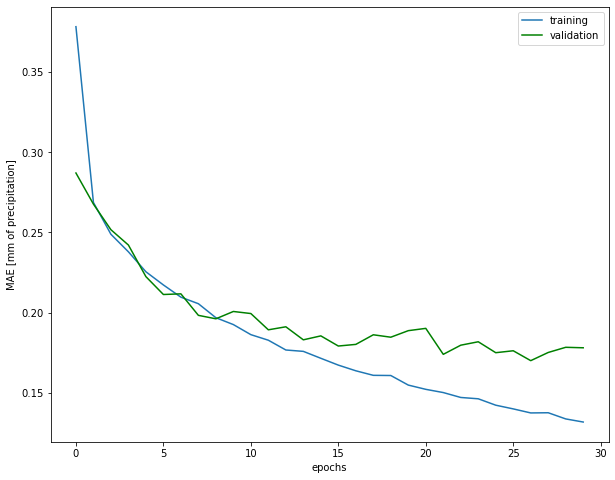

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

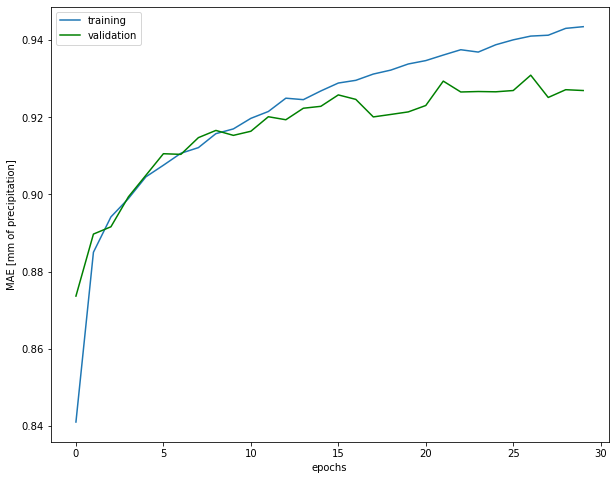

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.accuracy, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_accuracy, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

In [65]:
y_pred = model.predict(X_test)

In [66]:
y_test

,raining
90443,1
166417,1
54111,1
133524,1
62762,1
...,...
105922,1
101355,1
47987,1
24695,0


In [81]:
y_pred

array([[1.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       ...,
       [9.888203e-01],
       [6.258367e-08],
       [3.083288e-01]], dtype=float32)

In [46]:
from sklearn.metrics import mean_absolute_error, r2_score
error = mean_absolute_error(y_test, y_pred)
print(f'MAE: {error:.3f}')

rsqrd = r2_score(y_test, y_pred)
print(f'R-squared score: {rsqrd:.3f}')

MAE: 0.083
R-squared score: 0.725


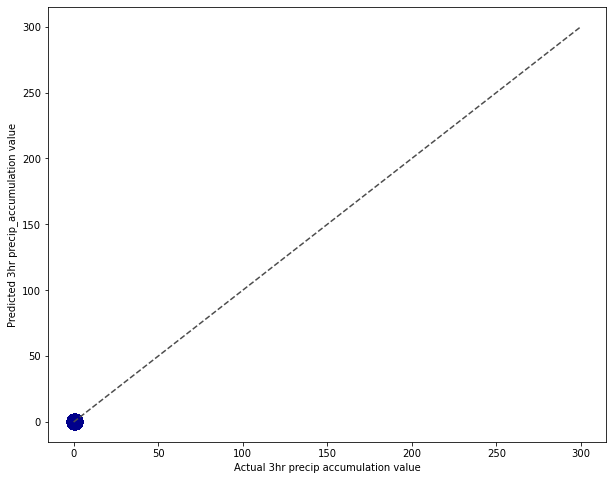

In [47]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")
plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

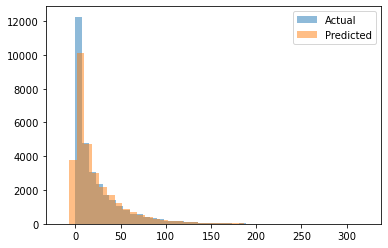

In [90]:
plt.figure(figsize=(10, 8))
plt.hist(y_test, alpha=0.5, bins=40, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
plt.legend()
plt.show()

## Control member only plots

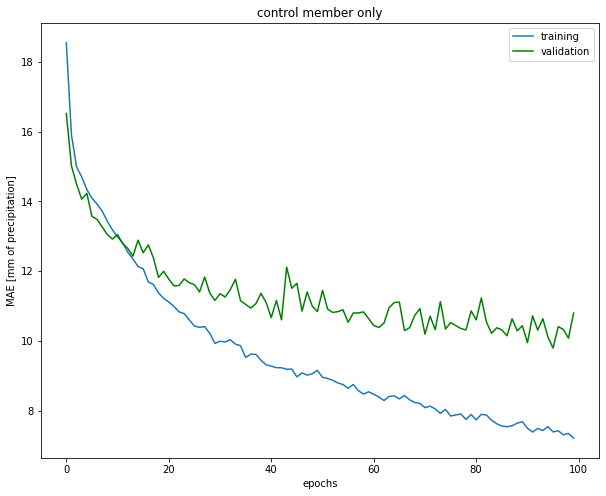

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.title('control member only')
plt.show()

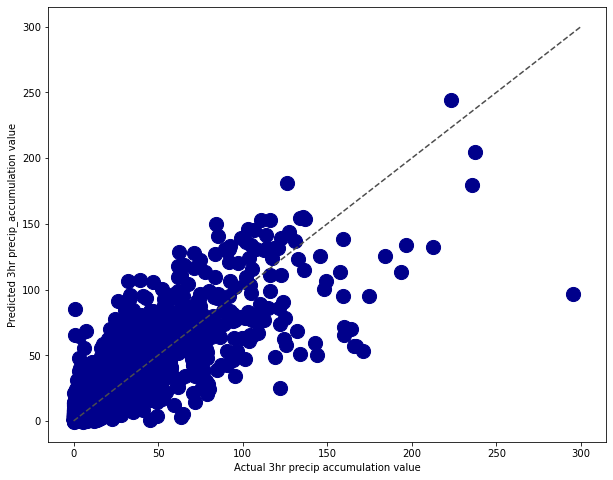

In [123]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")

plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

In [124]:
from sklearn.metrics import mean_absolute_error, r2_score
error = mean_absolute_error(y_test, y_pred)
print(f'MAE: {error:.3f}')

rsqrd = r2_score(y_test, y_pred)
print(f'R-squared score: {rsqrd:.3f}')

MAE: 11.381
R-squared score: 0.669


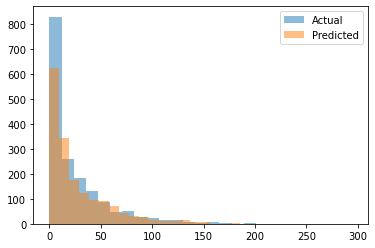

In [125]:
plt.figure(figsize=(10, 8))
plt.hist(y_test, alpha=0.5, bins=25, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=25, label='Predicted')
plt.legend()
plt.show()